In [1]:
import cv2
import os
from pathlib import Path

In [13]:
# Define paths
video_path = "../data/raw/train_video/video/trial.mp4"  # Path to the video file
frames_folder = "../data/raw/train_video/frames"        # Path to save extracted frames

video_path = Path(video_path).resolve()
output_folder = Path(frames_folder).resolve()


In [ ]:
def get_video_properties(video_path: str):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Unable to open video {video_path}")
        return None

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    fps = cap.get(cv2.CAP_PROP_FPS)

    duration = total_frames / fps if fps > 0 else 0
    
    cap.release()
    
    return {
        "total_frames": total_frames,
        "fps": fps,
        "duration": duration
    }

def extract_frames(video_path: str, output_folder: str, frame_skip: int = 1):
    os.makedirs(output_folder, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    saved_frames = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Save only every `frame_skip` frame
        if frame_count % frame_skip == 0:
            frame_filename = os.path.join(output_folder, f"frame_{saved_frames:04d}.jpg")
            cv2.imwrite(frame_filename, frame)
            saved_frames += 1

        frame_count += 1

    cap.release()
    print(f"Extracted {saved_frames} frames (every {frame_skip} frame) to {output_folder}")




Total frames: 310
FPS: 29.62
Duration: 10.47 seconds


In [ ]:
video_path = "../data/raw/train_video/video/trial.mp4"
video_properties = get_video_properties(video_path)

if video_properties:
    print(f"Total frames: {video_properties['total_frames']}")
    print(f"FPS: {video_properties['fps']:.2f}")
    print(f"Duration: {video_properties['duration']:.2f} seconds")


frame_skip = 5  
extract_frames(video_path, output_folder, frame_skip)


Extracted 62 frames (every 5 frame) to ../data/raw/train_video/frames/


In [4]:
import os
import xml.etree.ElementTree as ET
import pandas as pd

def voc_to_csv(annotations_folder: str, output_csv: str):
    """Convert Pascal VOC XML annotations to a CSV file.

    Args:
        annotations_folder (str): Path to the folder containing XML annotation files.
        output_csv (str): Path to save the resulting CSV file.
    """
    data = []

    # Iterate through all XML files in the annotations folder
    for file in os.listdir(annotations_folder):
        if file.endswith(".xml"):
            xml_path = os.path.join(annotations_folder, file)
            tree = ET.parse(xml_path)
            root = tree.getroot()

            # Extract image filename
            filename = root.find("filename").text

            # Extract image size
            size = root.find("size")
            width = int(size.find("width").text)
            height = int(size.find("height").text)

            # Extract object information
            for obj in root.findall("object"):
                label = obj.find("name").text
                bbox = obj.find("bndbox")
                xmin = int(bbox.find("xmin").text)
                ymin = int(bbox.find("ymin").text)
                xmax = int(bbox.find("xmax").text)
                ymax = int(bbox.find("ymax").text)

                # Append data as a row
                data.append([filename, width, height, label, xmin, ymin, xmax, ymax])

    # Convert to a Pandas DataFrame
    df = pd.DataFrame(data, columns=["filename", "width", "height", "label", "xmin", "ymin", "xmax", "ymax"])

    # Save to CSV
    df.to_csv(output_csv, index=False)
    print(f"Annotations successfully saved to {output_csv}")

# Example usage
annotations_folder = "../data/raw/train_video/annotations/"
output_csv = "../data/raw/train_video/annotations.csv"
voc_to_csv(annotations_folder, output_csv)


Annotations successfully saved to ../data/raw/train_video/annotations.csv


In [5]:
df = pd.read_csv(output_csv)
df.head(5)

,filename,width,height,label,xmin,ymin,xmax,ymax
0,frame_0000.jpg,480,848,plancha,267,211,391,351
1,frame_0001.jpg,480,848,plancha,269,227,419,373
2,frame_0002.jpg,480,848,plancha,272,306,430,463
3,frame_0003.jpg,480,848,plancha,296,393,425,530
4,frame_0004.jpg,480,848,plancha,319,404,454,548


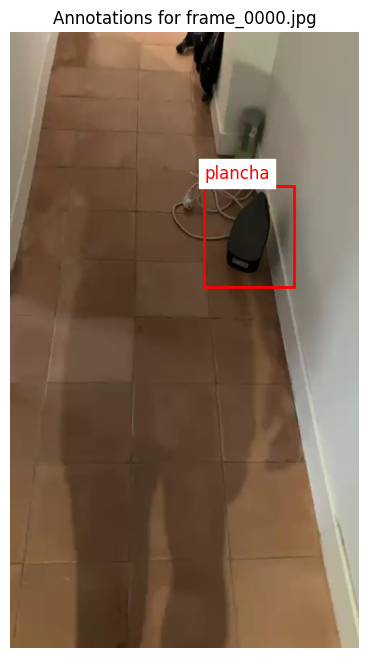

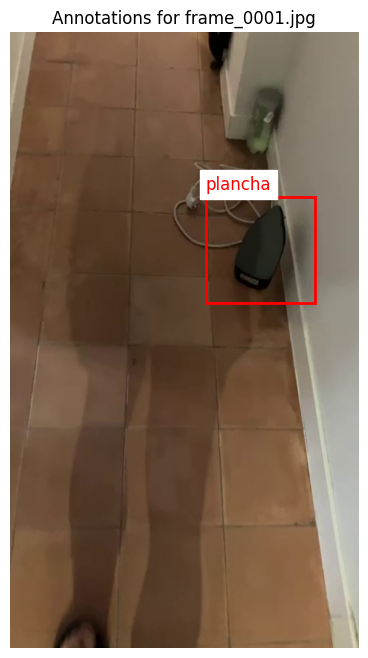

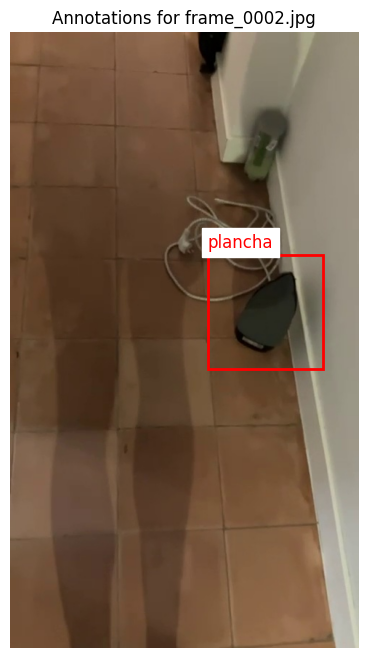

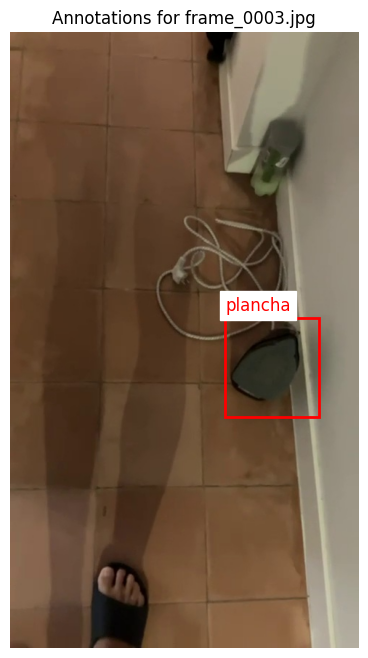

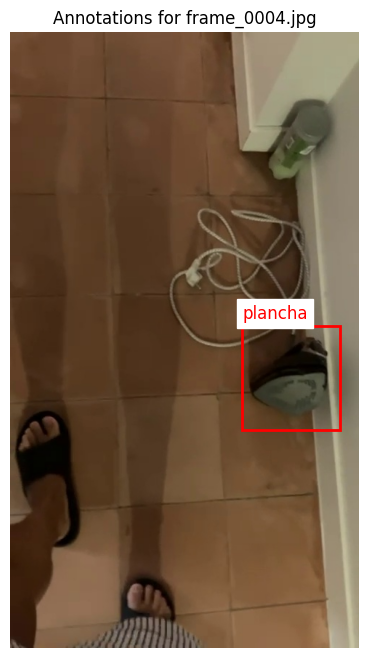

In [6]:
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd

def visualize_annotations(image_folder: str, annotations_csv: str, num_images: int = 5):
    """Visualizes images with bounding boxes from a CSV file.

    Args:
        image_folder (str): Path to the folder containing images.
        annotations_csv (str): Path to the CSV file with annotations.
        num_images (int): Number of images to visualize.
    """
    # Load the annotations
    df = pd.read_csv(annotations_csv)

    # Get unique filenames to limit the number of images plotted
    unique_files = df["filename"].unique()[:num_images]

    for filename in unique_files:
        # Read the image
        image_path = os.path.join(image_folder, filename)
        img = cv2.imread(image_path)
        if img is None:
            print(f"Image not found: {image_path}")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Plot the image
        plt.figure(figsize=(8, 8))
        plt.imshow(img)
        plt.axis("off")

        # Add bounding boxes
        image_annotations = df[df["filename"] == filename]
        for _, row in image_annotations.iterrows():
            x_min, y_min, x_max, y_max = row["xmin"], row["ymin"], row["xmax"], row["ymax"]
            label = row["label"]
            # Draw bounding box
            plt.gca().add_patch(
                plt.Rectangle(
                    (x_min, y_min),
                    x_max - x_min,
                    y_max - y_min,
                    linewidth=2,
                    edgecolor="red",
                    facecolor="none",
                )
            )
            # Add label text
            plt.text(
                x_min,
                y_min - 10,
                label,
                color="red",
                fontsize=12,
                backgroundcolor="white",
            )

        plt.title(f"Annotations for {filename}")
        plt.show()

# Example usage
image_folder = "../data/raw/train_video/frames/"
annotations_csv = "../data/raw/train_video/annotations.csv"
visualize_annotations(image_folder, annotations_csv, num_images=5)
